In [1]:
from datahelpers.constants import iden, ye, ai, ps, up, dn, ar, ni, cexp, qcexp, nw, wi, dist, rdist, bdist, pm, \
                                    cpop, cden, ct, affs, aus
from os.path import expanduser, join
import pandas as pd
from bm_support.add_features import generate_feature_groups
from bm_support.add_features import normalize_columns, select_feature_families, transform_last_stage
from bm_support.supervised_aux import study_sample, metric_selector
from functools import partial
from multiprocessing import Pool
from copy import deepcopy
import warnings
from numpy.random import RandomState
import gzip
import pickle
import argparse
import numpy as np
from numpy.random import RandomState
from bm_support.sampling import sample_by_length
from datahelpers.dftools import keep_longer_histories
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,\
    f1_score, classification_report, confusion_matrix, balanced_accuracy_score
from itertools import combinations, product
from bm_support.supervised import report_metrics_, train_massif, train_massif_clean, clean_zeros
from bm_support.supervised import invert_bayes, aggregate_over_claims_new, aggregate_over_claims_comm
from sklearn.linear_model import LogisticRegression
from bm_support.supervised_aux import find_optimal_model, produce_topk_model
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from bm_support.supervised_aux import simple_stratify
from numpy.random import RandomState
from bm_support.supervised_aux import find_optimal_model, produce_topk_model
from pprint import pprint

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 1
%aimport bm_support.supervised_aux
%aimport bm_support.add_features

In [2]:
ratios = (2., 1., 1.)
seed0 = 17
n_trials = 1
datapath = None
verbose = True
model_type = 'lr'
cooked_version = 12
origin = 'litgw'
version = 1
origin = 'gw'
version = 11

an_version = 20
an_version = 22
excl_columns=()
target = dist

min_log_alpha = -2
max_log_alpha = 2
log_reg_dict = {'min_log_alpha': min_log_alpha, 'max_log_alpha': max_log_alpha}

eps = 0.2
upper_exp, lower_exp = 1 - eps, eps
# thrs = [-1e-8, lower_exp, upper_exp, 1.0001e0]
if datapath:
    col_families = generate_feature_groups(expanduser(join(datapath, 'v14_columns.txt')))
else:
    col_families = generate_feature_groups(expanduser('~/data/kl/columns/v14_columns.txt'))

if verbose:
    print('Number of col families: {0}. Keys: {1}'.format(len(col_families), sorted(col_families.keys())))

col_families = {k: v for k, v in col_families.items() if 'future' not in k}
if verbose:
    print('Number of col families (excl. future): {0}. Keys: {1}'.format(len(col_families),
                                                                         sorted(col_families.keys())))

columns_interest = [x for sublist in col_families.values() for x in sublist]
if datapath:
    df_path = expanduser(join(datapath, '{0}_{1}_{2}.h5'.format(origin, version, cooked_version)))
else:
    df_path = expanduser('~/data/kl/final/{0}_{1}_{2}.h5'.format(origin, version, cooked_version))
df = pd.read_hdf(df_path, key='df')


feature_dict = deepcopy(col_families)

families = select_feature_families(an_version)
feature_dict = {k: v for k, v in feature_dict.items() if k in families}
excl_columns = list(set(excl_columns) | {target})

feature_dict = {k: list(v) for k, v in feature_dict.items() if not any([c in v for c in excl_columns])}

trial_features = [x for sublist in feature_dict.values() for x in sublist]

feature_dict_inv = {}
for k, v in feature_dict.items():
    feature_dict_inv.update({x: k for x in v})

# mask: not nulls in trial features
# df['obs_mu'].loc[df['obs_mu'].isnull()] = 0.5

['cpop', 'cden', 'ksst', 'nhi', 'affiliations_affind', 'authors_affind', 'future_affind', 'past_affind', 'affiliations_suppind', 'authors_suppind', 'future_suppind', 'past_suppind', 'affiliations_comm_size', 'authors_comm_size', 'future_comm_size', 'past_comm_size', 'affiliations_ncomms', 'authors_ncomms', 'future_ncomms', 'past_ncomms', 'affiliations_ncomponents', 'authors_ncomponents', 'future_ncomponents', 'past_ncomponents', 'pre_authors', 'pre_affs']
{'cpop': 8, 'cden': 8, 'ksst': 7, 'nhi': 2, 'affiliations_affind': 4, 'authors_affind': 4, 'future_affind': 4, 'past_affind': 4, 'affiliations_suppind': 4, 'authors_suppind': 4, 'future_suppind': 4, 'past_suppind': 4, 'affiliations_comm_size': 0, 'authors_comm_size': 0, 'future_comm_size': 0, 'past_comm_size': 0, 'affiliations_ncomms': 0, 'authors_ncomms': 0, 'future_ncomms': 0, 'past_ncomms': 0, 'affiliations_ncomponents': 0, 'authors_ncomponents': 0, 'future_ncomponents': 0, 'past_ncomponents': 0, 'pre_authors': 1, 'pre_affs': 1, 'c

In [3]:
touch_columns = list(set(trial_features) - {'obs_mu'})
dfw = transform_last_stage(df, touch_columns, origin, 0, False, verbose=False)
sum(df['obs_mu'].isnull()), sum(dfw['obs_mu'].isnull())

6626


(7110, 6626)

In [4]:
touch_columns = list(set(trial_features) - {'obs_mu'})
dfw = transform_last_stage(df, trial_features, origin, 2, False, verbose=False)
df_train, df_test = sample_by_length(dfw, (up, dn), head=10, seed=10, frac_test=0.3, verbose=True)
dfa_train, dfa_test = df_train[df_train['obs_mu'].isnull()].copy(), df_test[df_test['obs_mu'].isnull()].copy()
dfb_train, dfb_test = df_train[~df_train['obs_mu'].isnull()].copy(), df_test[~df_test['obs_mu'].isnull()].copy()

0
power law exponent: -1.891
6441
total size of train and test : 4504 1937
Ratio test to all: 0.3007297003570874. Should be 0.3
df_train power law exponent: -1.610
df_test power law exponent: -1.390


7110
power law exponent: -2.312
15494
total size of train and test : 10823 4671
Ratio test to all: 0.30147153736930427. Should be 0.3
df_train power law exponent: -2.208
df_test power law exponent: -2.543


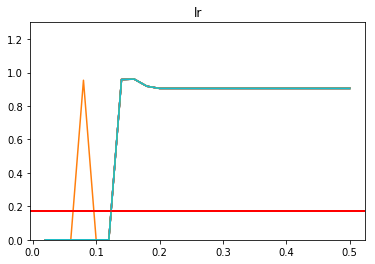

In [5]:
rns = RandomState(seed0)
n_trials = 10
nmax = 10000
seeds = rns.randint(nmax, size=n_trials)
# cur_features = list(set(trial_features) - {'obs_mu'})
# cur_features = list(set(trial_features) - {'obs_mu'})
cur_features = ['obs_mu']

touch_columns = list(set(cur_features) - {'obs_mu'})
dfw = transform_last_stage(df, touch_columns, origin, 0, False, verbose=False)
df_train, df_test = sample_by_length(dfw, (up, dn), head=10, seed=10, frac_test=0.3, verbose=True)
dfa_train, dfa_test = df_train[df_train['obs_mu'].isnull()].copy(), df_test[df_test['obs_mu'].isnull()].copy()
dfb_train, dfb_test = df_train[~df_train['obs_mu'].isnull()].copy(), df_test[~df_test['obs_mu'].isnull()].copy()

df_train, df_test = dfb_train, dfb_test

p_opts = []
feat_dict = []
for seed in seeds:
    df_train2 = simple_stratify(df_train, bdist, seed=seed, ratios=(2, 1))
    X_train, y_train = df_train2[cur_features], df_train2[bdist]
#     X_train, y_train = df_train[cur_features], df_train[bdist]
    clf, c_opt, acc_opt = find_optimal_model(X_train, y_train, 15)
    iis = np.nonzero(clf.coef_)[1]
    xs, ys, p_norm = produce_topk_model(clf, df_test, cur_features, bdist, 'lr')
    feat_dict.append((np.max(ys), {cur_features[ii]:clf.coef_[0, ii] for ii in iis}))
    p_opts.append((np.max(ys), p_norm))

In [6]:
pprint('out-sample mean prec: {0:.3f}, err: {1:.3f}, base {2:.3f}'.format(np.mean([x for x, _ in p_opts]), 
                                                         np.std([x for x, _ in p_opts]),
                                                                       1. - df_test[bdist].mean()))
pprint(feat_dict)

'out-sample mean prec: 0.961, err: 0.000, base 0.170'
[(0.9606557377049181, {'obs_mu': 5.353806909779701}),
 (0.9606557377049181, {'obs_mu': 4.3899042463097695}),
 (0.9606557377049181, {'obs_mu': 3.3882373904838268}),
 (0.9606557377049181, {'obs_mu': 4.398643807798623}),
 (0.9606557377049181, {'obs_mu': 5.66149423381061}),
 (0.9606557377049181, {'obs_mu': 3.4287986613934884}),
 (0.9606557377049181, {'obs_mu': 5.633353126594538}),
 (0.9606557377049181, {'obs_mu': 5.3443187100677285}),
 (0.9606557377049181, {'obs_mu': 3.41629638814016}),
 (0.9606557377049181, {'obs_mu': 3.4185868481641317})]


6626
power law exponent: -2.310
7926
total size of train and test : 5523 2403
Ratio test to all: 0.30317940953822864. Should be 0.3
df_train power law exponent: -1.913
df_test power law exponent: -2.331


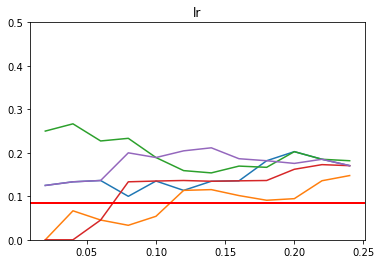

In [10]:
rns = RandomState(seed0)
n_trials = 5
nmax = 10000
seeds = rns.randint(nmax, size=n_trials)
# cur_features = list(set(trial_features) - {'obs_mu'})
cur_features = list(set(trial_features) - {'obs_mu'})

touch_columns = list(set(trial_features) - {'obs_mu'})
dfw = transform_last_stage(df, touch_columns, origin, 2, False, verbose=False)
df_train, df_test = sample_by_length(dfw, (up, dn), head=10, seed=10, frac_test=0.3, verbose=True)
dfa_train, dfa_test = df_train[df_train['obs_mu'].isnull()].copy(), df_test[df_test['obs_mu'].isnull()].copy()
dfb_train, dfb_test = df_train[~df_train['obs_mu'].isnull()].copy(), df_test[~df_test['obs_mu'].isnull()].copy()

df_train, df_test = dfa_train, dfa_test

p_opts = []
feat_dict = []
for seed in seeds:
    df_train2 = simple_stratify(df_train, bdist, seed=seed, ratios=(2, 1))
    X_train, y_train = df_train2[cur_features], df_train2[bdist]
#     X_train, y_train = df_train[cur_features], df_train[bdist]
    clf, c_opt, acc_opt = find_optimal_model(X_train, y_train, 15)
    iis = np.nonzero(clf.coef_)[1]
    xs, ys, p_norm = produce_topk_model(clf, df_test, cur_features, bdist, 'lr')
    feat_dict.append((np.max(ys), {cur_features[ii]:clf.coef_[0, ii] for ii in iis}))
    p_opts.append((np.max(ys), p_norm))

In [11]:
pprint('out-sample mean prec: {0:.3f}, err: {1:.3f}, base {2:.3f}'.format(np.mean([x for x, _ in p_opts]), 
                                                         np.std([x for x, _ in p_opts]),
                                                                       1. - df_test[bdist].mean()))
pprint(feat_dict)

'out-sample mean prec: 0.200, err: 0.040, base 0.084'
[(0.20270270270270271,
  {'A': 4.046473117923802e-05,
   'cite_count': -5.717501201437996e-05,
   'err': 9.193931407245904e-06,
   'int_3': 0.0007161310510524166,
   'lincs_comm_im_dir_unwei_p95_eff_comm_size': 0.0002007867003650633,
   'lincs_comm_im_dir_wei_pNone_eff_comm_size': 0.00020099763181531986,
   'lincs_comm_im_undir_unwei_p95_eff_comm_size': 0.03321158311536178,
   'lincs_comm_ml_undir_unwei_p95_eff_comm_size': -0.0008313940453321594,
   'lincs_comm_ml_undir_wei_pNone_eff_comm_size': -0.0001765133792619232,
   'litgw_comm_im_dir_unwei_p95_eff_comm_size': 0.00010766009897133723,
   'litgw_comm_im_dir_wei_pNone_eff_comm_size': -0.0010640699069745156,
   'litgw_comm_im_undir_unwei_p95_eff_comm_size': -0.016991023522767414,
   'litgw_comm_ml_undir_unwei_p95_eff_comm_size': 0.0005324566427038782,
   'litgw_comm_ml_undir_wei_pNone_eff_comm_size': -0.0010010864348363195,
   'mu': -0.01816910554346576}),
 (0.14772727272727273,
 

6626
power law exponent: -2.310
7926
total size of train and test : 5522 2404
Ratio test to all: 0.3033055765833964. Should be 0.3
df_train power law exponent: -1.970
df_test power law exponent: -2.355


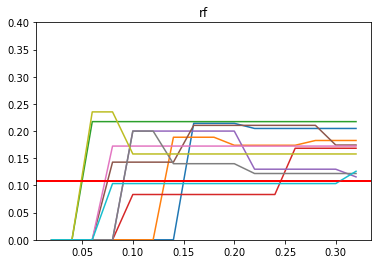

In [24]:
rns = RandomState(seed0)
n_trials = 10
nmax = 10000
seeds = rns.randint(nmax, size=n_trials)
# cur_features = list(set(trial_features) - {'obs_mu'})
cur_features = list(set(trial_features) - {'obs_mu'})

touch_columns = list(set(trial_features) - {'obs_mu'})
dfw = transform_last_stage(df, touch_columns, origin, 2, False, verbose=False)
df_train, df_test = sample_by_length(dfw, (up, dn), head=10, seed=11, frac_test=0.3, verbose=True)
dfa_train, dfa_test = df_train[df_train['obs_mu'].isnull()].copy(), df_test[df_test['obs_mu'].isnull()].copy()
dfb_train, dfb_test = df_train[~df_train['obs_mu'].isnull()].copy(), df_test[~df_test['obs_mu'].isnull()].copy()

df_train, df_test = dfa_train, dfa_test

p_opts = []
for seed in seeds:
#     df_train2 = df_train
    df_train2 = simple_stratify(df_train, bdist, seed=seed, ratios=(2, 1))
    X_train, y_train = df_train2[cur_features], df_train2[bdist]
    clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=seed)
    clf = clf.fit(X_train, y_train)
    xs, ys, p_norm = produce_topk_model(clf, df_test, cur_features, bdist, 'rf')
    p_opts.append((np.max(ys), p_norm))

In [25]:
pprint('out-sample mean prec: {0:.3f}, err: {1:.3f}, base {2:.3f}'.format(np.mean([x for x, _ in p_opts]), 
                                                         np.std([x for x, _ in p_opts]),
                                                                       1. - df_test[bdist].mean()))

'out-sample mean prec: 0.193, err: 0.030, base 0.108'


6626
power law exponent: -2.310
7926
total size of train and test : 5522 2404
Ratio test to all: 0.3033055765833964. Should be 0.3
df_train power law exponent: -1.970
df_test power law exponent: -2.355


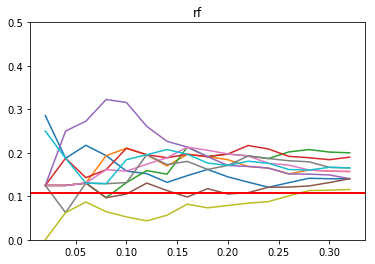

In [22]:
# rf
from sklearn.ensemble import RandomForestClassifier


rns = RandomState(seed0)
n_trials = 10
nmax = 10000
seeds = rns.randint(nmax, size=n_trials)
# cur_features = list(set(trial_features) - {'obs_mu'})
cur_features = list(set(trial_features) - {'obs_mu'})
touch_columns = list(set(trial_features) - {'obs_mu'})
dfw = transform_last_stage(df, touch_columns, origin, 2, False, verbose=False)
df_train, df_test = sample_by_length(dfw, (up, dn), head=10, seed=11, frac_test=0.3, verbose=True)
dfa_train, dfa_test = df_train[df_train['obs_mu'].isnull()].copy(), df_test[df_test['obs_mu'].isnull()].copy()
dfb_train, dfb_test = df_train[~df_train['obs_mu'].isnull()].copy(), df_test[~df_test['obs_mu'].isnull()].copy()

df_train, df_test = dfa_train, dfa_test

p_opts = []
for seed in seeds:
    df_train2 = df_train
#     df_train2 = simple_stratify(df_train, bdist, seed=seed, ratios=(2, 1))
    X_train, y_train = df_train2[cur_features], df_train2[bdist]
    clf = RandomForestClassifier(max_depth=4, min_samples_leaf=10, random_state=seed)
    clf = clf.fit(X_train, y_train)
    xs, ys, p_norm = produce_topk_model(clf, df_test, cur_features, bdist, 'rf')
    p_opts.append((np.max(ys), p_norm))

In [23]:
pprint('out-sample mean prec: {0:.3f}, err: {1:.3f}, base {2:.3f}'.format(np.mean([x for x, _ in p_opts]), 
                                                         np.std([x for x, _ in p_opts]),
                                                                       1. - df_test[bdist].mean()))

'out-sample mean prec: 0.216, err: 0.058, base 0.108'


In [26]:
for k in [2, 3, 4, 5, 6]:
    y_pred = clf.predict(X_train)
    acc = balanced_accuracy_score(y_train, y_pred, adjusted=True)
    acc = precision_score(y_train, y_pred,  pos_label=0)
    X_test, y_test = df_test[cur_features], df_test[bdist]
    y_pred_test = clf.predict(X_test)
    acc_test = balanced_accuracy_score(y_test, y_pred_test, adjusted=True)
    acc_test = precision_score(y_test, y_pred_test,  pos_label=0)
    print('{0} {1:.3f} {2:.3f}'.format(k, acc, acc_test))

2 0.957 0.103
3 0.957 0.103
4 0.957 0.103
5 0.957 0.103
6 0.957 0.103


6626
power law exponent: -2.310
7926
total size of train and test : 5522 2404
Ratio test to all: 0.3033055765833964. Should be 0.3
df_train power law exponent: -1.970
df_test power law exponent: -2.355


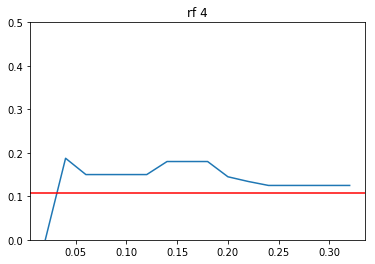

In [29]:
cur_features = list(set(trial_features) - {'obs_mu'})
touch_columns = list(set(trial_features) - {'obs_mu'})
dfw = transform_last_stage(df, touch_columns, origin, 2, False, verbose=False)
df_train, df_test = sample_by_length(dfw, (up, dn), head=10, seed=11, frac_test=0.3, verbose=True)
dfa_train, dfa_test = df_train[df_train['obs_mu'].isnull()].copy(), df_test[df_test['obs_mu'].isnull()].copy()
dfb_train, dfb_test = df_train[~df_train['obs_mu'].isnull()].copy(), df_test[~df_test['obs_mu'].isnull()].copy()

df_train, df_test = dfa_train, dfa_test

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=11)
X_train, y_train = df_train[cur_features], df_train[bdist]
clf = clf.fit(X_train, y_train)
xs, ys, p_norm = produce_topk_model(clf, df_test, cur_features, bdist, 'rf 4')

In [30]:
export_graphviz(clf, out_file=expanduser('~/tmp/tree.dot'))